# Phase 2: Analyze Data

Now that we have data on Databricks VM usage, we can analyze that data to understand how many VM's are being used and when they are being used.
With this data, we can see how we might optimize our compute configuration. We can also estimate how big our VM instance pools should be to
statisfy the compute requirements of our jobs.

In [0]:
import pyspark.sql.functions as F

delta_location = "dbfs:/vm-observation"

observations = spark.read.format("delta").load(delta_location + "/gold/observations")

In [0]:
display(observations.groupBy("subscriptionId", "workspaceName").agg(F.sum("count").alias("total_vm_minutes")).orderBy(F.col("total_vm_minutes").desc()))

subscriptionId,workspaceName,total_vm_minutes
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_pool_sizer,15507
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_jeremy,392


In [0]:
display(observations.groupBy("subscriptionId", "workspaceName", "JobName").agg(F.sum("count").alias("total_vm_minutes")).orderBy(F.col("total_vm_minutes").desc()))

subscriptionId,workspaceName,JobName,total_vm_minutes
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_pool_sizer,jp-adbx-job-quick,7646
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_pool_sizer,short - mid-size cluster,7111
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_pool_sizer,null,655
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_jeremy,null,392
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_pool_sizer,short - single-node,95


In [0]:
display(observations.groupBy("subscriptionId", "workspaceName", "vmSize").agg(F.sum("count").alias("total_vm_minutes")).orderBy(F.col("total_vm_minutes").desc()))

subscriptionId,workspaceName,vmSize,total_vm_minutes
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_pool_sizer,Standard_D3_v2,7741
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_pool_sizer,Standard_DS4_v2,7111
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_pool_sizer,Standard_DS12_v2,655
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_jeremy,Standard_DS3_v2,222
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_jeremy,Standard_F16s_v2,148
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_jeremy,Standard_F16,13
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_jeremy,Standard_DS4_v2,9


In [0]:
summary = observations \
            .groupBy("subscriptionId", "workspaceName", "vmSize", "JobName") \
            .agg(F.sum("count").alias("count"), F.min("date").alias("start"), F.max("date").alias("end"), F.max("count").alias("count_max"), F.min("count").alias("count_min"), F.countDistinct("ClusterName").alias("cluster_count")) \
            .withColumn("minutes", F.expr("((unix_timestamp(end) - unix_timestamp(start)) / 60) + 1")) \
            .withColumn("vms_per_min", F.expr("count / minutes")) \
            .orderBy("subscriptionId", "workspaceName", "vmSize", F.col("count").desc())

data = summary.collect()

subscriptionId = ""
workspaceName = ""
vmSize = ""

htmlCode = """
<!DOCTYPE html>
<meta charset="utf-8">
<style>
body {font-family: -apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji,FontAwesome;}
table {border-collapse: collapse;}
th, td {font-size: 9pt; min-width: 18pt; padding: 2pt;}
td:nth-child(5), td:nth-child(6), td:nth-child(7), td:nth-child(8), td:nth-child(9), td:nth-child(10) {text-align: right; min-width: 54pt}
tr.s td {font-size: 12pt; font-weight: bold; background-color: #cccccc;}
tr.w td {font-size: 11pt; font-weight: bold; background-color: #dddddd;}
tr.v td {font-size: 10pt; background-color: #eeeeee;}
</style>
<body><div class="markdown"><table>
<thead><tr><th></th><th></th><th></th><th style=\"text-align: left\">Job Name</th><th>Total VM<br />Minutes</th><th>Concurrent<br/>VMs - Max</th><th>Concurrent<br/>VMs - Min</th><th>Total<br />Minutes</th><th>VMs per<br />Minute</th><th>Number<br />of Runs</th></tr></thead>
<tbody>
"""

for row in data:
    if row[0] != subscriptionId:
        subscriptionId = row[0]
        htmlCode += f"<tr class=\"s\"><td colspan=\"10\">Subscription: {subscriptionId}</td></tr>"

    if row[1] != workspaceName:
        workspaceName = row[1]
        htmlCode += f"<tr class=\"w\"><td></td><td colspan=\"9\">Workspace: {workspaceName}</td></tr>"

    if row[2] != vmSize:
        vmSize = row[2]
        htmlCode += f"<tr class=\"v\"><td></td><td></td><td colspan=\"8\">VM SKU: {vmSize}</td></tr>"

    jobName = row[3] if row[3] else "[non-job cluster]"
    run_count = format(row[9], ",") if row[3] else "-"
    htmlCode += f"<tr><td></td><td></td><td></td><td>{jobName}</td><td>{row[4]:,}</td><td>{row[7]:,}</td><td>{row[8]:,}</td><td>{int(row[10]):,}</td><td>{row[11]:.2f}</td><td>{run_count}</td></tr>"

htmlCode += "</tbody></table></div></body></html>"

displayHTML(htmlCode)

<!DOCTYPE html>
 

 
 Job Name Total VM Minutes Concurrent VMs - Max Concurrent VMs - Min Total Minutes VMs per Minute Number of Runs 
 
 Subscription: 6de50f6f-dc7e-431d-96ea-53da23ade313 Workspace: adbx_jeremy VM SKU: Standard_DS3_v2 [non-job cluster] 222 1 1 1,297 0.17 - VM SKU: Standard_DS4_v2 [non-job cluster] 9 1 1 9 1.00 - VM SKU: Standard_F16 [non-job cluster] 13 1 1 13 1.00 - VM SKU: Standard_F16s_v2 [non-job cluster] 148 1 1 351 0.42 - Workspace: adbx_pool_sizer VM SKU: Standard_D3_v2 jp-adbx-job-quick 7,646 2 1 2,832 2.70 142 short - single-node 95 1 1 2,180 0.04 3 VM SKU: Standard_DS12_v2 [non-job cluster] 655 2 1 329 1.99 - VM SKU: Standard_DS4_v2 short - mid-size cluster 7,111 2 1 2,818 2.52 183

## Analyzing Usage for Frequently Occuring Jobs
Analysis above looks at all VM usage in Databricks, including VM's that aren't part of on-demand job clusters.  This is useful data
to understand Databricks compute consumption across an entire enterprise.  However, to make progress, we need to re-focus on our
core purpose here:  We want to increase the resiliency of our regularly occuring Databricks jobs.  We will do this by identifying
jobs that are currently powered by on-demand job clusters and move those to Instance Pools.  Therefore, we do not need to be concerned
about interactive clusters or jobs that are already running with Instance Pools.  We also don't need to worry about jobs that run
sporadically.

To that end, the rest of the analysis in this notebook will focus only on "frequent jobs".  These are jobs that appear often in the
logs during the period of time for which we gathered usage data.

In [0]:
dates = observations.agg(F.min("date"), F.max("date")).collect()[0]
range_start = dates[0]
range_end   = dates[1]
range_minutes = (range_end - range_start).total_seconds() / 60

frequent_jobs = observations \
                    .groupBy("subscriptionId", "location", "workspaceName", "vmSize", "JobName") \
                    .agg(F.min("date").alias("start"), F.max("date").alias("end")) \
                    .withColumn("minutes", F.expr("((unix_timestamp(end) - unix_timestamp(start)) / 60) + 1")) \
                    .withColumn("percentage", F.col("minutes") / F.lit(range_minutes)) \
                    .filter("JobName IS NOT NULL AND vmSize IS NOT NULL AND percentage > 0.75")

### VM SKU Variety
Each Instance Pool in Databricks can only contain one type of VM.  If we are using many different types of VM's, then we will have to
create many instance pools.  That can create extra management overhead.  It can also reduce the efficiency of our pools because spare
VM's from one instance pool cannot be used to fill demand in another pool.

Therefore, to make our instance pools more efficient, we should consider reducing the number of SKU's that we use as much as possible.
In some cases, you may have done very careful testing to select the exact VM SKU that optimizes your workload.  But in other cases
(and it seems to be the most common case), a data engineer may have just blindly selected a VM type without putting any thought into it.
For these jobs, we might consider changing the VM type and consolidating many jobs into just a few VM types.

In the report, a red exclamation mark (❗) is used to indicate an older version of a VM type if you are also using a newer version of
that same type.  The report also highlights usage of the "Standard_DS3_v2" VM type.  There's nothing wrong with this VM type (it's great, actually!),
but it's the default option when creating a compute cluster in Azure Databricks.  It is highlighted simply to illustrate how often your data
engineers simply accept the default instead of carefully selecting a VM type.

In [0]:
from pyspark.sql.window import Window

vm_skus = spark.read.format("delta").load(delta_location + "/silver/vm_skus")

sku_usage = observations \
                .join(frequent_jobs, on=["subscriptionId", "location", "workspaceName", "vmSize", "JobName"], how="inner") \
                .groupBy("subscriptionId", "location", "workspaceName", "vmSize") \
                .agg(F.countDistinct("JobName").alias("job_count"), F.sum("count").alias("count"))

order_by_cols = ["subscriptionId", "workspaceName", "series", "family", "number_of_cores", "vmSize"]
window_spec = Window.partitionBy("subscriptionId", "workspaceName", "series").orderBy(order_by_cols)

sku_usage = sku_usage \
                .join(vm_skus, (sku_usage.subscriptionId == vm_skus.subscription_id) & (sku_usage.location == vm_skus.location) & (sku_usage.vmSize == vm_skus.name), how="left_outer") \
                .withColumn("next_name_without_version", F.lead("name_without_version").over(window_spec)) \
                .orderBy(order_by_cols) \
                .selectExpr("subscriptionId", "workspaceName", "COALESCE(series, 'Unknown') AS series", "family", "vmSize", "next_name_without_version", "name_without_version", "description", "count", "job_count", "number_of_cores", "memory_in_gb", "has_premium_storage", "is_amd", "has_local_temp_disk")

data = sku_usage.collect()

subscriptionId = ""
workspaceName = ""
series = ""

htmlCode = """
<!DOCTYPE html>
<meta charset="utf-8">
<style>
body {font-family: -apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji,FontAwesome;}
table {border-collapse: collapse;}
th, td {font-size: 9pt; min-width: 18pt; padding: 2pt;}
td:nth-child(5), td:nth-child(6), td:nth-child(7), td:nth-child(8) {text-align: right; min-width: 54pt}
td:nth-child(9), td:nth-child(10), td:nth-child(11) {text-align: center; min-width: 54pt}
tr.s td {font-size: 12pt; font-weight: bold; background-color: #cccccc;}
tr.w td {font-size: 11pt; font-weight: bold; background-color: #dddddd;}
tr.v td {font-size: 10pt; background-color: #eeeeee;}
tr.highlight td {background-color: orange; color: white}
</style>
<body><div class="markdown"><table>
<thead><tr><th></th><th></th><th></th><th style=\"text-align: left\">VM SKU</th><th>Total VM<br />Minutes</th><th>Job<br/>Count</th><th>vCPUs</th><th>Memory</th><th>Premium<br/>Storage</th><th>AMD<br />processor</th><th>Local<br />Temp Disk</th></tr></thead>
<tbody>
"""

for row in data:
    row_dict = row.asDict()
    if row[0] != subscriptionId:
        subscriptionId = row[0]
        htmlCode += f"<tr class=\"s\"><td colspan=\"11\">Subscription: {subscriptionId}</td></tr>"

    if row[1] != workspaceName:
        workspaceName = row[1]
        htmlCode += f"<tr class=\"w\"><td></td><td colspan=\"10\">Workspace: {workspaceName}</td></tr>"

    if row[2] != series:
        series = row[2]
        htmlCode += f"<tr class=\"v\"><td></td><td></td><td colspan=\"9\">"
        htmlCode += f"<b>{series} series</b><br />"
        htmlCode += f"<span style=\"font-size: 8pt; font-weight: normal\">{row_dict['description']}</span></td></tr>"

    htmlCode += f"<tr{' class=''highlight''' if row_dict['vmSize'] == 'Standard_DS3_v2' else ''}><td></td><td></td><td></td>"
    htmlCode += f"<td>{row_dict['vmSize']}{' &#10071;' if row_dict['name_without_version'] == row_dict['next_name_without_version'] else ''}</td>"
    htmlCode += f"<td>{row_dict['count']:,}</td>"
    htmlCode += f"<td>{row_dict['job_count']:,}</td>"
    htmlCode += f"<td>{row_dict['number_of_cores']:,}</td>"
    htmlCode += f"<td>{int(row_dict['memory_in_gb'])}</td>"
    htmlCode += f"<td>{'&#9989;' if row_dict['has_premium_storage'] else ''}</td>"
    htmlCode += f"<td>{'&#9989;' if row_dict['is_amd'] else ''}</td>"
    htmlCode += f"<td>{'&#9989;' if row_dict['has_local_temp_disk'] else ''}</td>"
    htmlCode += f"</tr>"

htmlCode += "</tbody></table></div></body></html>"

displayHTML(htmlCode)

<!DOCTYPE html>
 

 
 VM SKU Total VM Minutes Job Count vCPUs Memory Premium Storage AMD processor Local Temp Disk 
 
 Subscription: 6de50f6f-dc7e-431d-96ea-53da23ade313 Workspace: adbx_pool_sizer General purpose series Balanced CPU-to-memory ratio. Ideal for testing and development, small to medium databases, and low to medium traffic web servers. Standard_D3_v2 7,741 2 4 14 Standard_DS4_v2 7,111 1 8 28

In [0]:
from pyspark.sql.window import Window

order_by_cols = ["subscriptionId", "location", "workspaceName", "vmSize", "JobName", "start_date"]
window_spec = Window.partitionBy("subscriptionId", "location", "workspaceName", "vmSize", "JobName").orderBy(order_by_cols)

job_runs = observations \
            .filter("JobName IS NOT NULL AND vmSize IS NOT NULL") \
            .groupBy("subscriptionId", "location", "workspaceName", "vmSize", "JobName", "JobId", "ClusterName", "RunName") \
            .agg(F.sum("count").alias("total_count"), F.avg("count").alias("vms_per_minute"), F.min("date").alias("start_date"), F.max("date").alias("end_date")) \
            .withColumn("run_minutes", F.expr("(UNIX_TIMESTAMP(end_date) - UNIX_TIMESTAMP(start_date)) / 60")) \
            .withColumn("previous_start_date", F.lag("start_date").over(window_spec)) \
            .withColumn("hours_between_starts", F.expr("(UNIX_TIMESTAMP(start_date) - UNIX_TIMESTAMP(previous_start_date)) / 3600.0")) \
            .orderBy(order_by_cols)

display(job_runs)

subscriptionId,location,workspaceName,vmSize,JobName,JobId,ClusterName,RunName,total_count,vms_per_minute,start_date,end_date,run_minutes,previous_start_date,hours_between_starts
6de50f6f-dc7e-431d-96ea-53da23ade313,eastus,adbx_pool_sizer,Standard_D3_v2,jp-adbx-job-quick,57071771572976,job-57071771572976-run-763745414404910-Job_cluster,jp-adbx-job-quick,34,1.4782608695652173,2023-11-07T16:10:00Z,2023-11-07T16:21:00Z,11.0,null,null
6de50f6f-dc7e-431d-96ea-53da23ade313,eastus,adbx_pool_sizer,Standard_D3_v2,jp-adbx-job-quick,57071771572976,job-57071771572976-run-336466019112228-Job_cluster,jp-adbx-job-quick,36,1.5,2023-11-07T16:30:00Z,2023-11-07T16:41:00Z,11.0,2023-11-07T16:10:00Z,0.333333
6de50f6f-dc7e-431d-96ea-53da23ade313,eastus,adbx_pool_sizer,Standard_D3_v2,jp-adbx-job-quick,57071771572976,job-57071771572976-run-959910287994843-Job_cluster,jp-adbx-job-quick,36,1.5,2023-11-07T16:50:00Z,2023-11-07T17:01:00Z,11.0,2023-11-07T16:30:00Z,0.333333
6de50f6f-dc7e-431d-96ea-53da23ade313,eastus,adbx_pool_sizer,Standard_D3_v2,jp-adbx-job-quick,57071771572976,job-57071771572976-run-110053862942148-Job_cluster,jp-adbx-job-quick,36,1.5,2023-11-07T17:10:00Z,2023-11-07T17:21:00Z,11.0,2023-11-07T16:50:00Z,0.333333
6de50f6f-dc7e-431d-96ea-53da23ade313,eastus,adbx_pool_sizer,Standard_D3_v2,jp-adbx-job-quick,57071771572976,job-57071771572976-run-271185631302277-Job_cluster,jp-adbx-job-quick,58,1.2608695652173914,2023-11-07T17:30:00Z,2023-11-07T18:03:00Z,33.0,2023-11-07T17:10:00Z,0.333333
6de50f6f-dc7e-431d-96ea-53da23ade313,eastus,adbx_pool_sizer,Standard_D3_v2,jp-adbx-job-quick,57071771572976,job-57071771572976-run-796419401350927-Job_cluster,jp-adbx-job-quick,98,1.1395348837209303,2023-11-07T17:50:00Z,2023-11-07T19:03:00Z,73.0,2023-11-07T17:30:00Z,0.333333
6de50f6f-dc7e-431d-96ea-53da23ade313,eastus,adbx_pool_sizer,Standard_D3_v2,jp-adbx-job-quick,57071771572976,job-57071771572976-run-590149996369997-Job_cluster,jp-adbx-job-quick,39,1.5,2023-11-07T18:10:00Z,2023-11-07T18:22:00Z,12.0,2023-11-07T17:50:00Z,0.333333
6de50f6f-dc7e-431d-96ea-53da23ade313,eastus,adbx_pool_sizer,Standard_D3_v2,jp-adbx-job-quick,57071771572976,job-57071771572976-run-146577941861200-Job_cluster,jp-adbx-job-quick,36,1.5,2023-11-07T18:30:00Z,2023-11-07T18:41:00Z,11.0,2023-11-07T18:10:00Z,0.333333
6de50f6f-dc7e-431d-96ea-53da23ade313,eastus,adbx_pool_sizer,Standard_D3_v2,jp-adbx-job-quick,57071771572976,job-57071771572976-run-587415079999908-Job_cluster,jp-adbx-job-quick,52,1.2682926829268293,2023-11-07T18:50:00Z,2023-11-07T19:19:00Z,29.0,2023-11-07T18:30:00Z,0.333333
6de50f6f-dc7e-431d-96ea-53da23ade313,eastus,adbx_pool_sizer,Standard_D3_v2,jp-adbx-job-quick,57071771572976,job-57071771572976-run-402253656479278-Job_cluster,jp-adbx-job-quick,56,1.2444444444444445,2023-11-07T19:10:00Z,2023-11-07T19:43:00Z,33.0,2023-11-07T18:50:00Z,0.333333


In [0]:
vm_counts = observations \
                .filter("JobName IS NOT NULL") \
                .groupBy("subscriptionId", "workspaceName", "vmSize", "JobName", "date") \
                .agg(F.sum("count").alias("count"))

all_dates = spark.range(0, range_minutes).withColumn("date", F.lit(range_start) + F.expr("MAKE_INTERVAL(0, 0, 0, 0, 0, id)")).drop("id").orderBy("date")

df = frequent_jobs.select("subscriptionId", "workspaceName", "vmSize", "JobName") \
        .crossJoin(all_dates)

df = df \
        .join(vm_counts.alias("v"), ["subscriptionId", "workspaceName", "vmSize", "JobName", "date"], "leftouter") \
        .withColumn("count", F.coalesce(F.col("count"), F.lit(0))) \
        .groupBy("subscriptionId", "workspaceName", "vmSize", "jobName", "date") \
        .agg(F.sum("count").alias("count")) \
        .withColumn("job_active", F.expr("CASE WHEN count > 0 THEN jobName ELSE NULL END")) \
        .cache()

display( df.groupBy("subscriptionId", "workspaceName", "vmSize").agg(F.min("count"), F.max("count").alias("max_count")) )

subscriptionId,workspaceName,vmSize,min(count),max_count
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_pool_sizer,Standard_DS4_v2,0,3
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_pool_sizer,Standard_D3_v2,0,4


## Inspection by VM SKU

In [0]:
subscription_id = "6de50f6f-dc7e-431d-96ea-53da23ade313"
workspace_name = "adbx_pool_sizer"
vm_size = "Standard_DS4_v2"

In [0]:
subset = df.filter(f"subscriptionId == '{subscription_id}' AND workspaceName == '{workspace_name}' AND vmSize == '{vm_size}'")
subset = subset.withColumn("minute", F.minute("date"))
subset = subset.withColumn("job_active", F.expr("CASE WHEN count > 0 THEN jobName ELSE NULL END"))
subset = subset.groupBy("subscriptionId", "workspaceName", "vmSize", "minute").agg(F.sum("count").alias("count"), F.countDistinct("job_active").alias("job_count"))
display(subset)

subscriptionId,workspaceName,vmSize,minute,count,job_count
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_pool_sizer,Standard_DS4_v2,17,45,1
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_pool_sizer,Standard_DS4_v2,5,132,1
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_pool_sizer,Standard_DS4_v2,54,141,1
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_pool_sizer,Standard_DS4_v2,7,138,1
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_pool_sizer,Standard_DS4_v2,12,141,1
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_pool_sizer,Standard_DS4_v2,35,141,1
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_pool_sizer,Standard_DS4_v2,38,141,1
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_pool_sizer,Standard_DS4_v2,6,134,1
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_pool_sizer,Standard_DS4_v2,34,141,1
6de50f6f-dc7e-431d-96ea-53da23ade313,adbx_pool_sizer,Standard_DS4_v2,0,141,1


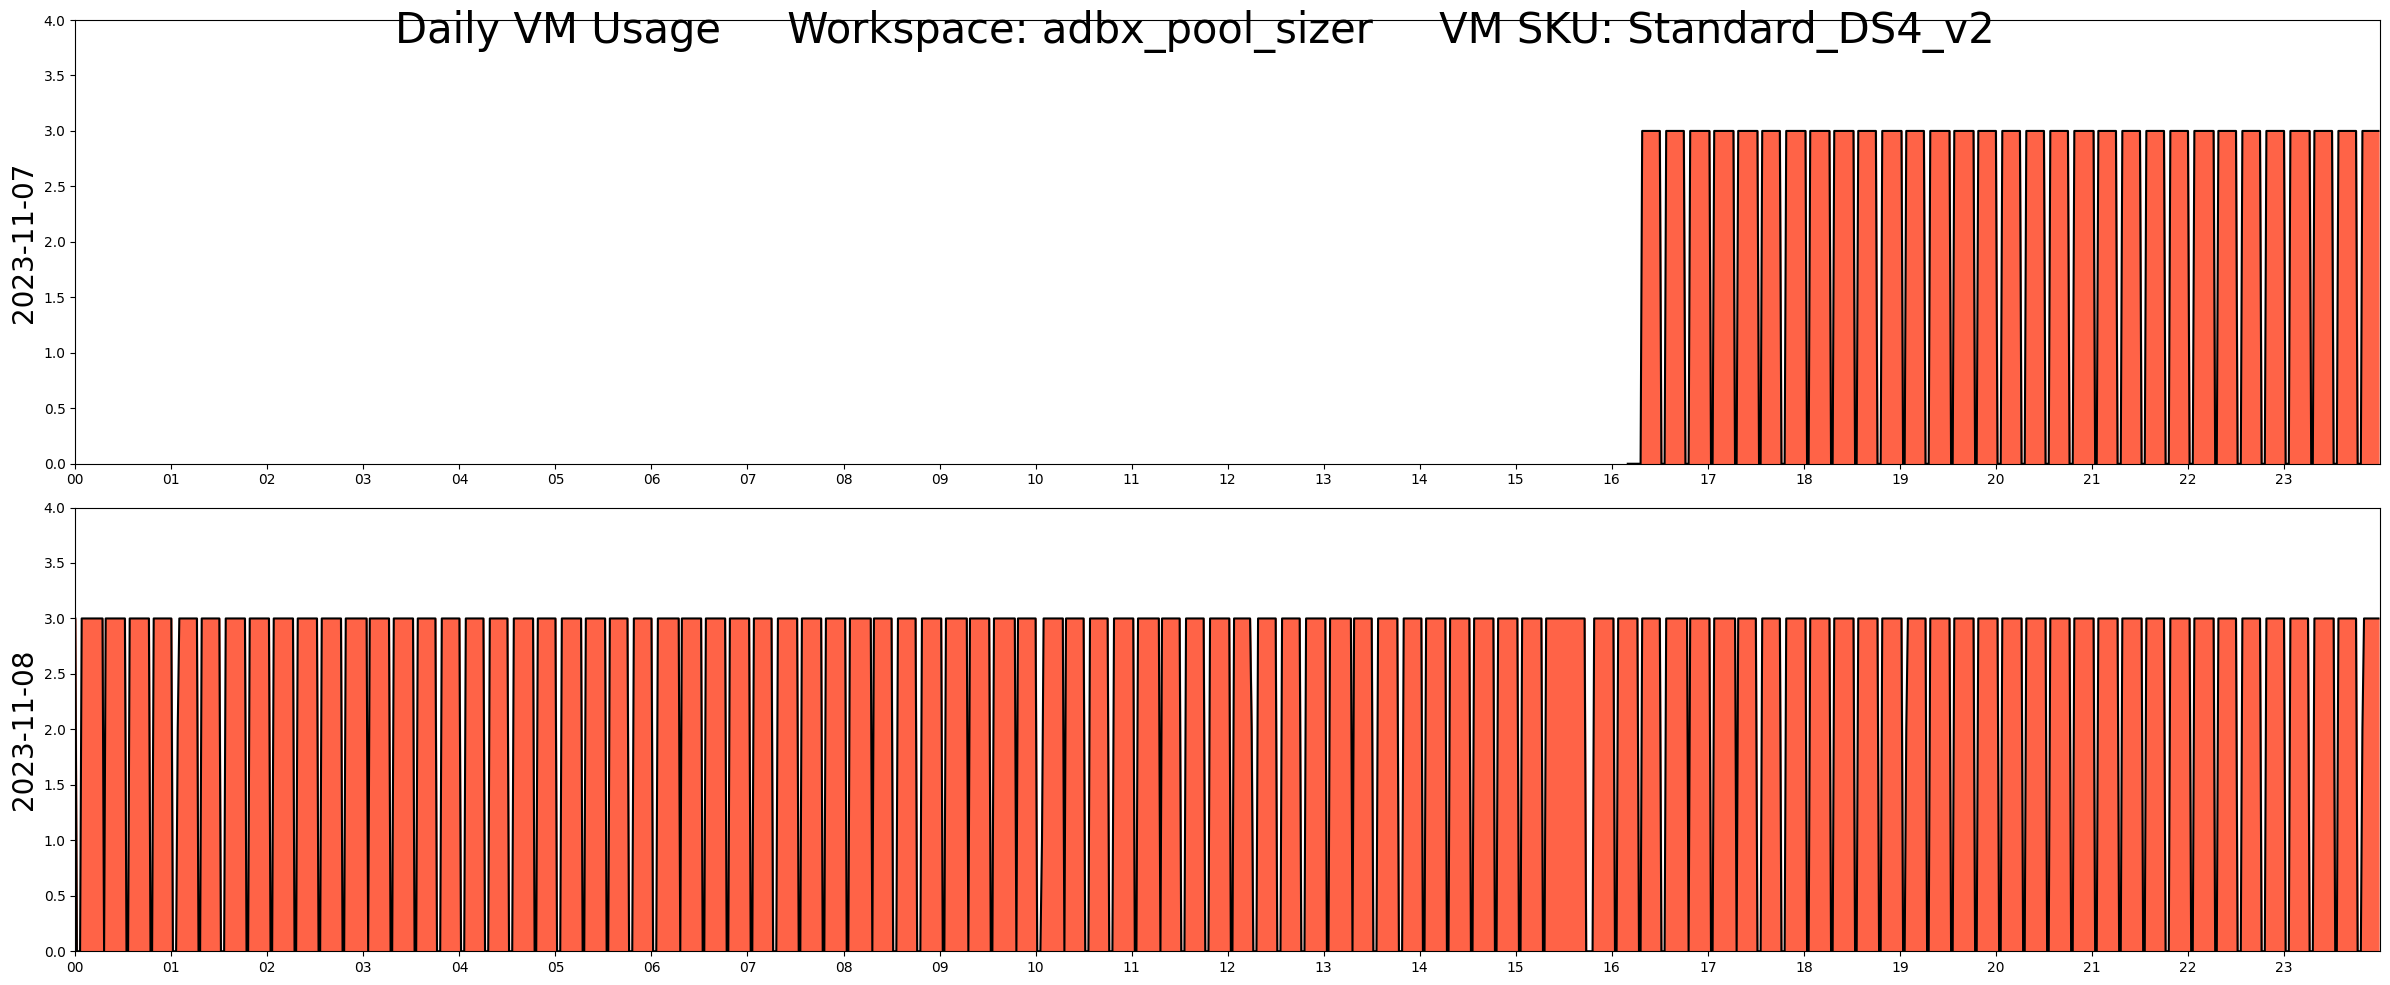

In [0]:
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

date_range = observations.agg(F.min("date"), F.max("date")).collect()[0]
first_full_day = date_range[0].date() + timedelta(days = 1)
last_full_day  = date_range[1].date() - timedelta(days = 1)
days_count = (last_full_day - first_full_day).days + 1
days = [first_full_day + timedelta(days=i) for i in range(0, days_count)]

daily = df \
            .withColumn("day", F.to_date("date")) \
            .withColumn("time", F.expr("date - MAKE_INTERVAL(0, 0, 0, DATEDIFF(date, '2000-01-01'))")) \
            .filter(f"subscriptionId == '{subscription_id}' AND workspaceName == '{workspace_name}' AND vmSize == '{vm_size}'") \
            .filter(f"day BETWEEN '{first_full_day}' AND '{last_full_day}'") \
            .groupBy("subscriptionId", "workspaceName", "vmSize", "date", "day", "time") \
            .agg(F.sum("count").alias("count")) \
            .cache()

max_count = daily.agg(F.max("count")).collect()[0][0]
fig, ax = plt.subplots(days_count, 1, figsize=(24, (4 * days_count) + 2))
hour_locator = mdates.HourLocator(interval=1)
hour_formatter = mdates.DateFormatter("%H")

for i, day in enumerate(days):
    data = daily.filter(f"day = '{day}'").orderBy("date").toPandas()
    X = data["time"]
    Y = data["count"]

    ax[i].plot(X, Y, color='black')
    ax[i].fill_between(X, Y, 0, color='tomato')

    ax[i].xaxis.set_major_locator(hour_locator)
    ax[i].xaxis.set_major_formatter(hour_formatter)
    ax[i].set_ylim([0, max_count + 1])
    ax[i].set_xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2000-01-01 23:59:59'))
    ax[i].set_ylabel(day, fontsize=20)

fig.tight_layout()
fig.suptitle(f"Daily VM Usage     Workspace: {workspace_name}     VM SKU: {vm_size}", fontsize=30)
fig.subplots_adjust(top=0.97)